# Advanced Model: Prophet
This notebook builds and evaluates a Prophet model to forecast Bitcoin transaction fees over the next 24 hours, based on 15-minute interval data from the mempool dataset.

### Why Prophet?

During exploratory data analysis (EDA), we observed:

- Clear daily and weekly seasonality in fee patterns,

- Sudden spikes in fees due to network congestion (potential "holidays"),

- Multiple changepoints, indicating regime shifts or structural breaks.

The Prophet model is well-suited for this context because it:

- Handles nonlinear trends with automatic changepoint detection,

- Supports multiple seasonalities (daily, weekly, and custom),

- Allows incorporation of holiday effects (e.g., congestion spikes),

- Is robust to missing data and outliers.

This notebook demonstrates the full modeling process using Prophet, including customization of seasonalities and holidays.

### Import required libraries

In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np
import seaborn as sns
from prophet.diagnostics import cross_validation, performance_metrics
import itertools
import json

In [2]:
import sys
sys.path.append("../src/")
from preprocess_raw_parquet import preprocess_raw_parquet
from prophet_utils import model_optimization,create_model_new,create_model_new_holiday,mae_with_std_and_shape_penalty,get_result_new,evaluate_model,evaluate_model_external,evaluate_best_model
from plot_series import plot_series

### Load data

We begin with loading the preprocessed dataset specifically prepared for Prophet models.

In [3]:
df_new = preprocess_raw_parquet("../data/raw/mar_5_may_12.parquet")
df_new.dropna(inplace = True)
df_new.head()

,mempool_blocks_blockSize,mempool_blocks_blockVSize,mempool_blocks_nTx,mempool_blocks_totalFees,mempool_blocks_medianFee,recommended_fee_fastestFee,recommended_fee_halfHourFee,recommended_fee_hourFee,recommended_fee_economyFee,recommended_fee_minimumFee,...,mempool_fee_histogram_bin_70_75,mempool_fee_histogram_bin_75_80,mempool_fee_histogram_bin_80_85,mempool_fee_histogram_bin_85_90,mempool_fee_histogram_bin_90_95,mempool_fee_histogram_bin_95_100,mempool_fee_histogram_bin_100_150,mempool_fee_histogram_bin_150_200,mempool_fee_histogram_bin_200_250,mempool_fee_histogram_bin_250_300
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-03-05 02:00:00,2.170952e+06,997895.375000,793.000000,1.846754e+06,1.300111,2.000000,2.000000,2.000000,2.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:15:00,1.801526e+06,997925.916667,2627.000000,3.407913e+06,2.473960,3.000000,2.666667,2.666667,2.666667,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:30:00,2.055350e+06,997965.916667,922.000000,1.855358e+06,1.355898,2.000000,2.000000,2.000000,2.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:45:00,2.006800e+06,997970.083333,1296.666667,2.167251e+06,1.536092,2.333333,2.333333,2.333333,2.333333,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 03:00:00,1.773658e+06,997960.333333,2725.333333,3.462741e+06,2.467659,3.333333,3.000000,3.000000,3.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Split train and test data
Recommanded fastest fee rate is our target. Here we choose the last 24-hour data as the test data and the others as training data. Because of spikes in the last day, we remove the last 24-hour from the dataset.

In [4]:
df_new = df_new.iloc[:-96]
y_new = df_new["recommended_fee_fastestFee"]
X_new = df_new.drop(columns = "recommended_fee_fastestFee")
X_new = X_new.reset_index()
X_new = X_new.drop(columns = "timestamp")

# last 24h as test
split_index = len(X_new) - 96

X_train_new, X_test_new = X_new.iloc[:split_index], X_new.iloc[split_index:]
y_train_new, y_test_new = y_new.iloc[:split_index], y_new.iloc[split_index:]


The input to Prophet is always a dataframe with two columns: ds and y. The ds (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp. The y column must be numeric, and represents the measurement we wish to forecast.

In [5]:
df_prophet_new = y_train_new.reset_index()
df_prophet_new = df_prophet_new.rename(columns={
    'timestamp': 'ds',
    'recommended_fee_fastestFee': 'y'
})
df_prophet_new['y'] = np.log1p(df_prophet_new['y'])
df_prophet_new.head()

,ds,y
0,2025-03-05 02:00:00,1.098612
1,2025-03-05 02:15:00,1.386294
2,2025-03-05 02:30:00,1.098612
3,2025-03-05 02:45:00,1.203973
4,2025-03-05 03:00:00,1.466337


### Optimization - Find the best params

We choose GridSearch to optimize the model. Here are the ranges of parameters.

changepoint_prior_scale controls the model’s flexibility to adapt to changes in trend. A smaller value makes the trend smoother (less sensitive to abrupt changes), while a larger value allows more flexibility.

seasonality_prior_scale adjusts the strength of the seasonal components. Higher values allow more complex seasonal patterns, which is useful if the data shows strong seasonality.

seasonality_mode can be 'additive' or 'multiplicative', depending on whether seasonal effects are constant or scale with the level of the series. Since fee levels can change dramatically, it's important to compare both.

changepoint_range defines the portion of the historical data in which Prophet will look for potential changepoints. We test different values to balance early and recent trend shifts.

n_changepoints sets how many potential changepoints the model should consider. More changepoints allow better flexibility but can risk overfitting.

In [6]:
param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 0.3, 0.5],
    'seasonality_prior_scale': [5.0, 10.0, 20.0],
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_range': [0.8, 0.9, 0.95],
    'n_changepoints': [25, 50, 100]
}
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

Our base Prophet model is constructed with:

- No automatic daily or weekly seasonality, because we explicitly add customized seasonality components based on domain knowledge.

- A custom hourly seasonality (period=1/24) to capture intraday fee fluctuations, which are prominent in high-frequency transaction data.

- A daily seasonality to model repeated daily behavior (e.g., daytime congestion).

- A weekly seasonality to reflect usage patterns across different days of the week.

This structured setup allows fine control over periodic patterns, avoids overfitting from default assumptions, and better reflects the temporal structure of transaction fee data at 15-minute intervals.

In [ ]:
results = model_optimization(df_prophet_new, all_params)

The best hyperparameter is changepoint_prior_scale: 0.01, seasonality_prior_scale: 10.0, seasonality_mode: multiplicative, changepoint_range: 0.9, n_changepoints: 25. 

In [ ]:
best_params = sorted(results, key=lambda x: x[1])[0]
with open("saved_models/prophet.json", "w") as f:
    json.dump(best_params[0], f, indent=4)
print(f"Best params：{best_params[0]}\nRMSE：{best_params[1]:.4f}")

### Forecasting and evaluation 

We use the best parameters to build a new model. Then we fit the train data and make predictions. 

In [6]:
model = create_model_new()
model.fit(df_prophet_new)
future = model.make_future_dataframe(periods=96, freq='15min')
forecast = model.predict(future)
# model.plot_components(forecast)

22:40:53 - cmdstanpy - INFO - Chain [1] start processing
22:40:53 - cmdstanpy - INFO - Chain [1] done processing


We get the results, calculate the metrics and compare the results with actual data. 

MAE: 1.4978
RMSE: 1.8401
MAPE: 0.8828
MAE with std and shape penalty: 4.4933
Base MAE: 0.9097
Base RMSE: 1.1087
Base MAPE: 0.5078
Base MAE with std and shape penalty: 2.7292


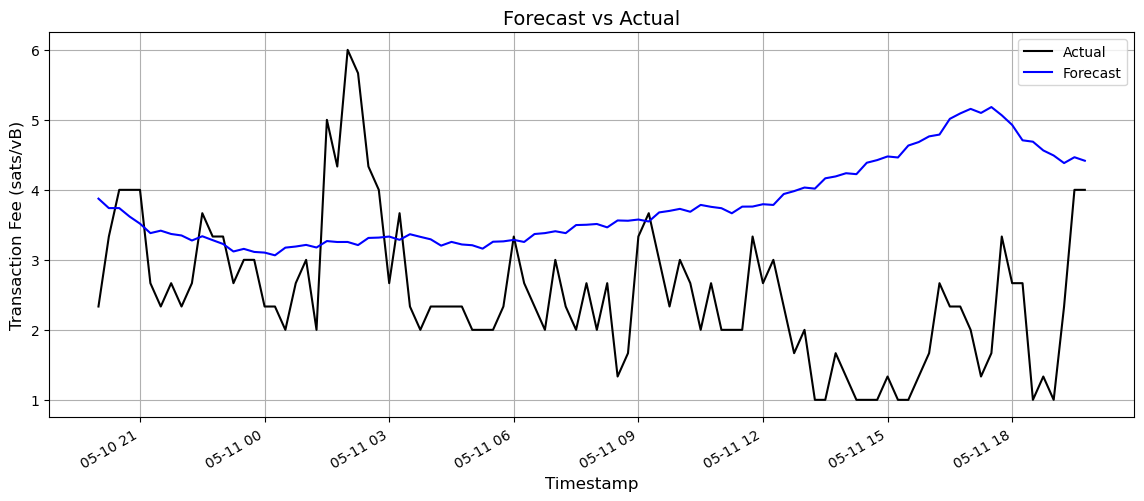

In [ ]:
# get_result_new(forecast,y_test_new,y_new)

To better evaluate the model, since the dataset contains 10-week data, we split the dataset into 10 different datasets. Each of the new datasets contain 1-week data. We create 10 new models to seperately fit the datasets, and calculate every set of metrics and the average ones. 

In [ ]:
metrics_per_week, avg_metrics = evaluate_model(df_new)
print("\nAverage metrics over all weeks:")
for k, v in avg_metrics.items():
    print(f"{k}: {v:.4f}")

22:41:02 - cmdstanpy - INFO - Chain [1] start processing
22:41:02 - cmdstanpy - INFO - Chain [1] done processing
22:41:02 - cmdstanpy - INFO - Chain [1] start processing
22:41:02 - cmdstanpy - INFO - Chain [1] done processing
22:41:02 - cmdstanpy - INFO - Chain [1] start processing
22:41:02 - cmdstanpy - INFO - Chain [1] done processing
22:41:02 - cmdstanpy - INFO - Chain [1] start processing
22:41:02 - cmdstanpy - INFO - Chain [1] done processing
22:41:02 - cmdstanpy - INFO - Chain [1] start processing
22:41:02 - cmdstanpy - INFO - Chain [1] done processing
22:41:02 - cmdstanpy - INFO - Chain [1] start processing
22:41:02 - cmdstanpy - INFO - Chain [1] done processing
22:41:02 - cmdstanpy - INFO - Chain [1] start processing
22:41:02 - cmdstanpy - INFO - Chain [1] done processing
22:41:02 - cmdstanpy - INFO - Chain [1] start processing
22:41:02 - cmdstanpy - INFO - Chain [1] done processing
22:41:02 - cmdstanpy - INFO - Chain [1] start processing
22:41:03 - cmdstanpy - INFO - Chain [1]


Average metrics over all weeks:
avg_mae: 1.6599
avg_rmse: 2.3623
avg_mape: 0.4827
avg_mae_std: 4.9796
base_avg_mae: 1.4486
base_avg_rmse: 2.2695
base_avg_mape: 0.3667
base_avg_mae_std: 4.3458


## Add external features

The prophet model also supports exogenous features, so we try to add the features. Here we shift the entire feature forward by 24 hours. It is like using features from time t to predict the target at time t+24hours. 

In [9]:
metrics_per_week, avg_metrics = evaluate_model_external(df_new)
print("\nAverage metrics over all weeks:")
for k, v in avg_metrics.items():
    print(f"{k}: {v:.4f}")

22:41:16 - cmdstanpy - INFO - Chain [1] start processing
22:41:16 - cmdstanpy - INFO - Chain [1] done processing
22:41:16 - cmdstanpy - INFO - Chain [1] start processing
22:41:16 - cmdstanpy - INFO - Chain [1] done processing
22:41:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
22:41:16 - cmdstanpy - INFO - Chain [1] start processing
22:41:18 - cmdstanpy - INFO - Chain [1] done processing
22:41:18 - cmdstanpy - INFO - Chain [1] start processing
22:41:18 - cmdstanpy - INFO - Chain [1] done processing
22:41:18 - cmdstanpy - INFO - Chain [1] start processing
22:41:18 - cmdstanpy - INFO - Chain [1] done processing
22:41:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
22:41:18 - cmdstanpy - INFO - Chain [1] start processing
22:41:23 - cmdstanpy - INFO - Chain [1] done processing
22:41:23 -


Average metrics over all weeks:
avg_mae: 1797984.5379
avg_rmse: 2104035.6191
avg_mape: 855393.1319
avg_mae_std: 5393953.6138
base_avg_mae: 1.4462
base_avg_rmse: 2.2699
base_avg_mape: 0.3627
base_avg_mae_std: 4.3385


The performance is far from good. Because Prophet is not a lag-aware or sequence-based model. 

## Set holidays

Prophet also supports manually setting holiday parameters. In this case, we found the best choice was to define holidays as the timestamps corresponding to the top 10% of the values. The log-transformed values increased by 25% percent in holidays compared to the baseline trend. 

In [10]:
model_holiday = create_model_new_holiday(y_train_new)
model_holiday.fit(df_prophet_new)
future = model_holiday.make_future_dataframe(periods=96, freq='15min')
forecast = model_holiday.predict(future)
# model_holiday.plot_components(forecast)

22:41:40 - cmdstanpy - INFO - Chain [1] start processing
22:41:40 - cmdstanpy - INFO - Chain [1] done processing


MAE: 1.0098
RMSE: 1.3430
MAPE: 0.5807
MAE with std and shape penalty: 3.0293
Base MAE: 0.9097
Base RMSE: 1.1087
Base MAPE: 0.5078
Base MAE with std and shape penalty: 2.7292


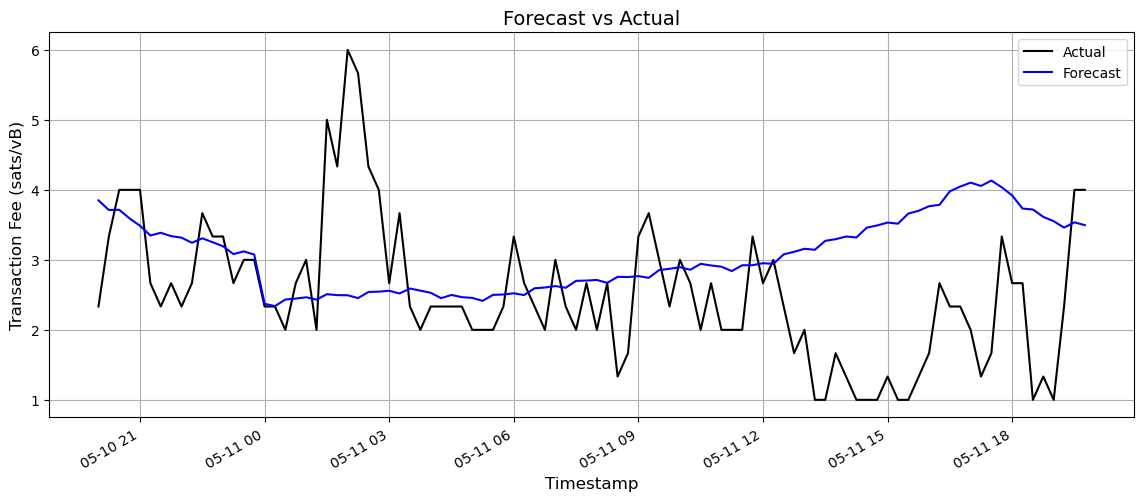

In [11]:
get_result_new(forecast,y_test_new,y_new)

In [12]:
metrics_per_week, avg_metrics = evaluate_model(df_new,holiday = 1)
print("\nAverage metrics over all weeks:")
for k, v in avg_metrics.items():
    print(f"{k}: {v:.4f}")

22:41:45 - cmdstanpy - INFO - Chain [1] start processing
22:41:45 - cmdstanpy - INFO - Chain [1] done processing
22:41:45 - cmdstanpy - INFO - Chain [1] start processing
22:41:45 - cmdstanpy - INFO - Chain [1] done processing
22:41:45 - cmdstanpy - INFO - Chain [1] start processing
22:41:45 - cmdstanpy - INFO - Chain [1] done processing
22:41:45 - cmdstanpy - INFO - Chain [1] start processing
22:41:45 - cmdstanpy - INFO - Chain [1] done processing
22:41:45 - cmdstanpy - INFO - Chain [1] start processing
22:41:45 - cmdstanpy - INFO - Chain [1] done processing
22:41:45 - cmdstanpy - INFO - Chain [1] start processing
22:41:46 - cmdstanpy - INFO - Chain [1] done processing
22:41:46 - cmdstanpy - INFO - Chain [1] start processing
22:41:46 - cmdstanpy - INFO - Chain [1] done processing
22:41:46 - cmdstanpy - INFO - Chain [1] start processing
22:41:46 - cmdstanpy - INFO - Chain [1] done processing
22:41:46 - cmdstanpy - INFO - Chain [1] start processing
22:41:46 - cmdstanpy - INFO - Chain [1]


Average metrics over all weeks:
avg_mae: 1.5958
avg_rmse: 2.3077
avg_mape: 0.4310
avg_mae_std: 4.7875
base_avg_mae: 1.4486
base_avg_rmse: 2.2695
base_avg_mape: 0.3667
base_avg_mae_std: 4.3458


## The best model

Based on the results, model with manual set holiday parameters performs the best. Then we would use the model to train the whole data.

22:41:50 - cmdstanpy - INFO - Chain [1] start processing
22:41:50 - cmdstanpy - INFO - Chain [1] done processing


MAE: 1.0098
RMSE: 1.3430
MAPE: 0.5807
MAE with std and shape penalty: 3.0293
Base MAE: 0.9097
Base RMSE: 1.1087
Base MAPE: 0.5078
Base MAE with std and shape penalty: 2.7292


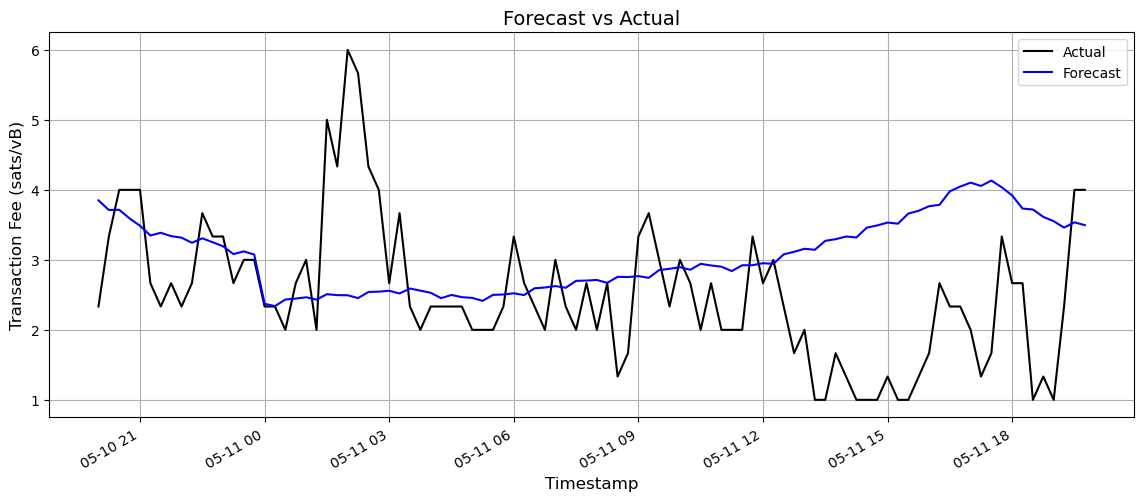

In [13]:
evaluate_best_model(df_new)


## Conclusion

The performance is not as good as baseline. We should try other advanced models.